# Cebra hybrid dir

In [33]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os

import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import spikeinterface as si
import numpy as np
from collections import Counter
import pandas as pd
import warnings
import pickle
from sklearn.preprocessing import LabelEncoder
import yaml

# dimensionality reduction
from cebra import CEBRA
import cebra
import torch

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

# GET STIMULUS CONF
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config

data_conf, _ = get_config("silico_neuropixels", "stimulus").values()
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH = data_conf["probe_wiring"]["output"]


# GET STIM-REP CONF
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/stim-rep"
os.chdir(PROJ_PATH)

with open(
    f"conf/silico_npx/stimulus/dataset.yml",
    "r",
    encoding="utf-8",
) as data_conf:
    data_conf = yaml.safe_load(data_conf)

# MODELS
CEBRA_MODEL_MTLYR_TRIAL_PATH = data_conf['models']['cebra']['models']['multilayer_trialwise']

# EMBEDDINGS
CEBRA_EMBED_MTLYR_TRIAL_PATH = data_conf['models']['cebra']['embed']['multilayer_trialwise']

# TASK DESIGN PARAMETERS
N_SIMS = 36 # number of simulation files
N_REP = 50

# FIGURE SETTINGS
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True, "dpi":300} 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-05-12 20:24:04,476 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-12 20:24:04,502 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Custom functions

In [2]:
def get_stimulus_intervals_ms(epoch_labels, epoch_ms):

    # find stimulus epoch starts and ends
    epoch_end_ms = np.cumsum(epoch_ms)
    epoch_start_ms = np.hstack([0, epoch_end_ms])[:-1]
    df = pd.DataFrame(data=epoch_end_ms)
    df.columns = ["end"]
    df.insert(0, "start", epoch_start_ms)
    df.index = epoch_labels

    # get stimulus intervals
    return [tuple(df.iloc[ix]) for ix in range(len(df)) if df.index[ix] == "stimulus"]


def get_stimulus_labels():
    start = np.arange(0, 360, 10)
    end = np.arange(10, 370, 10)

    stimulus_labels = []
    for ix in range(36):
        stimulus_labels.append(np.repeat(np.arange(start[ix], end[ix], 1), 50))
    return np.array(stimulus_labels).flatten()


def get_task_parameters(
    start_delay=500,
    n_orientations=10,
    n_repeats=50,
    stimulus_duration=200,
    n_simulations=36,
):
    # get epoch timings
    epoch_ms = n_simulations * (
        [start_delay] + n_orientations * n_repeats * [stimulus_duration]
    )
    # get epoch labels
    epoch_labels = n_simulations * (
        ["delay"] + n_orientations * n_repeats * ["stimulus"]
    )

    return {"epoch_labels": epoch_labels, "epoch_ms": epoch_ms}


def get_evoked_responses(spike_trains_ms: np.array, stim_intervals_ms: np.array):
    """_summary_

    Args:
        spike_trains_ms (np.array): _description_
        stim_intervals_ms (np.array): array of tuples (start, end)

    Returns:
        _type_: _description_
    """
    # Use numpy's digitize function to find the bin indices for each value
    bins = [interval[1] for interval in stim_intervals_ms]

    # Return the indices of the bins to which each value in spike_trains_ms belongs.
    bin_indices = np.digitize(spike_trains_ms, bins=bins)

    # Use Counter to count occurrences of bin indices
    interval_counter = Counter(bin_indices)

    # find active stimulus epochs
    active_bin_spike_count = [items[1] for items in list(interval_counter.items())]
    active_bin_ix = [items[0] for items in list(interval_counter.items())]

    # cast unit responses by stimulus epoch in an array
    unit_responses = np.zeros(len(bins))
    unit_responses[active_bin_ix] = active_bin_spike_count
    return unit_responses


def convert_spike_trains_to_ms(spike_trains: np.array, sfreq: int):
    """_summary_

    Args:
        spike_trains (np.array): _description_
        sfreq (int): _description_

    Returns:
        _type_: _description_
    """
    sample_ms = 1 / (sfreq / 1000)
    spike_trains_ms = spike_trains * sample_ms
    return spike_trains_ms


def compute_response_by_stim_matrix(unit_ids, SortingTrueKS3, stimulus_intervals_ms):
    """_summary_

    Args:
        SortingTrueKS3 (_type_): _description_
        stimulus_intervals_ms (_type_): _description_

    Returns:
        _type_: _description_
    """
    SFREQ = SortingTrueKS3.get_sampling_frequency()

    # takes 18 secs
    responses = []
    for unit_id in unit_ids:
        spike_trains = SortingTrueKS3.get_unit_spike_train(unit_id)
        spike_trains_ms = convert_spike_trains_to_ms(spike_trains, SFREQ)
        responses.append(get_evoked_responses(spike_trains_ms, stimulus_intervals_ms))
    return np.array(responses)


import sklearn


# # custom functions
# def split(response, labels, test_ratio):

#     split_idx = int(response.shape[1] * (1 - test_ratio))
#     neural_train = response[:, :split_idx]
#     neural_test = response[:, split_idx:]
#     label_train = labels[:split_idx]
#     label_test = labels[split_idx:]

#     return (
#         neural_train,
#         neural_test,
#         label_train,
#         label_test,
#     )


def split(trial_labels, n_rep, train_ratio: float = 0.8):
    # get 0.80 of trial repeats by direction as train and the remaining trial repeats as test
    train_max_trial_id = int(n_rep * train_ratio)
    train_idx = np.where(trial_labels <= train_max_trial_id)[0]
    test_idx = np.where(trial_labels > train_max_trial_id)[0]
    return (train_idx, test_idx)


def decode(embed_train, embed_test, label_train, label_test):
    """decoding using a k-Nearest Neighbor clustering technique
    We use the fixed number of neighbors 36
    """
    # predict
    decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")
    decoder.fit(embed_train, label_train)
    prediction = decoder.predict(embed_test)

    # calculate error
    test_err = np.median(abs(prediction - label_test))
    test_r2 = sklearn.metrics.r2_score(label_test, prediction)
    return test_err, test_r2

### Load dataset

In [3]:
# sorting
SortingTrue = si.load_extractor(GT_SORTING_PATH)

# unit layers
unit_layers = SortingTrue.get_property("layer")
print("# of unit layers:", len(np.unique(unit_layers)))
print("unique unit layers:", np.unique(unit_layers))

# recording
Recording = si.load_extractor(RECORDING_PATH)
print("# of units:", len(SortingTrue.unit_ids))

# get task epoch infos
task = get_task_parameters(
    start_delay=500,
    n_orientations=10,
    n_repeats=50,
    stimulus_duration=200,
    n_simulations=36,
)

# STIMULUS  ***********

# get stimulus labels
stimulus_labels = get_stimulus_labels().astype(float)
print("# of stimulus trials:", len(stimulus_labels))
print("# of stimulus orientations:", len(np.unique(stimulus_labels)))

# get stimulus orientation labels
stimulus_intervals_ms = get_stimulus_intervals_ms(
    task["epoch_labels"], task["epoch_ms"]
)

print("orientations:", stimulus_intervals_ms)

# TRIALS   ***********

trial_labels = np.tile(np.arange(0, N_REP, 1), len(np.unique(stimulus_labels))).astype(
    float
)

# NEURAL RESPONSE ***********

# compute unit x stimulus response matrix
responses = compute_response_by_stim_matrix(
    SortingTrue.unit_ids, SortingTrue, stimulus_intervals_ms
)

# UNIT LABELS ***********

syn = SortingTrue.get_property("synapse_class")
enc = LabelEncoder()
unit_labels = [
    np.array([enc.fit_transform(syn[(unit_layers == "2") | (unit_layers == "3")])])
    .astype(np.float32)
    .T,
    np.array([enc.fit_transform(syn[unit_layers == "4"])]).astype(np.float32).T,
    np.array([enc.fit_transform(syn[unit_layers == "5"])]).astype(np.float32).T,
    np.array([enc.fit_transform(syn[unit_layers == "6"])]).astype(np.float32).T,
]

# of unit layers: 6
unique unit layers: ['1' '2' '3' '4' '5' '6']
# of units: 1836
# of stimulus trials: 18000
# of stimulus orientations: 360
orientations: [(500, 700), (700, 900), (900, 1100), (1100, 1300), (1300, 1500), (1500, 1700), (1700, 1900), (1900, 2100), (2100, 2300), (2300, 2500), (2500, 2700), (2700, 2900), (2900, 3100), (3100, 3300), (3300, 3500), (3500, 3700), (3700, 3900), (3900, 4100), (4100, 4300), (4300, 4500), (4500, 4700), (4700, 4900), (4900, 5100), (5100, 5300), (5300, 5500), (5500, 5700), (5700, 5900), (5900, 6100), (6100, 6300), (6300, 6500), (6500, 6700), (6700, 6900), (6900, 7100), (7100, 7300), (7300, 7500), (7500, 7700), (7700, 7900), (7900, 8100), (8100, 8300), (8300, 8500), (8500, 8700), (8700, 8900), (8900, 9100), (9100, 9300), (9300, 9500), (9500, 9700), (9700, 9900), (9900, 10100), (10100, 10300), (10300, 10500), (10500, 10700), (10700, 10900), (10900, 11100), (11100, 11300), (11300, 11500), (11500, 11700), (11700, 11900), (11900, 12100), (12100, 12300)

### (11m) Cebra-hyb-aux:dir


#### EXC each layer

In [12]:
np.random.seed(0)
torch.manual_seed(0)

MAX_ITER = 8000
LOAD = True

# exc responses
data_l23_exc = responses[(unit_layers == "2") | (unit_layers == "3"), :][
    np.where(unit_labels[0] == 0)[0], :
]
data_l4_exc = responses[(unit_layers == "4"), :][np.where(unit_labels[1] == 0)[0], :]
data_l5_exc = responses[(unit_layers == "5"), :][np.where(unit_labels[2] == 0)[0], :]
data_l6_exc = responses[(unit_layers == "6"), :][np.where(unit_labels[3] == 0)[0], :]

labels = np.array([stimulus_labels]).astype(float).T

if not LOAD:

    model_cfg = {
        "model_architecture": "offset10-model",
        "batch_size": 1200,
        "learning_rate": 1e-4,
        "temperature": 1,
        "output_dimension": 3,
        "max_iterations": MAX_ITER,  # 8000,
        "distance": "cosine",
        "conditional": "time_delta",
        "device": "cuda_if_available",
        "verbose": True,
        "time_offsets": 10,
        "hybrid": True,
    }

    # cebra - behavior model
    cebra_l23_model = CEBRA(**model_cfg)
    cebra_l4_model = CEBRA(**model_cfg)
    cebra_l5_model = CEBRA(**model_cfg)
    cebra_l6_model = CEBRA(**model_cfg)

    # train and save
    cebra_l23_model.fit(data_l23_exc.T, labels)
    cebra_l23_model.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l23_exc.pt"
    )
    cebra_l4_model.fit(data_l4_exc.T, labels)
    cebra_l4_model.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l4_exc.pt"
    )
    cebra_l5_model.fit(data_l5_exc.T, labels)
    cebra_l5_model.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l5_exc.pt"
    )
    cebra_l6_model.fit(data_l6_exc.T, labels)
    cebra_l6_model.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l6_exc.pt"
    )

else:
    cebra_l23_model = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l23_exc.pt"
    )
    cebra_l4_model = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l4_exc.pt"
    )
    cebra_l5_model = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l5_exc.pt"
    )
    cebra_l6_model = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l6_exc.pt"
    )

# embedding
cebra_l23_embed = cebra_l23_model.transform(data_l23_exc.T)
cebra_l4_embed = cebra_l4_model.transform(data_l4_exc.T)
cebra_l5_embed = cebra_l5_model.transform(data_l5_exc.T)
cebra_l6_embed = cebra_l6_model.transform(data_l6_exc.T)

# align to L2/3
alignment = cebra.data.helper.OrthogonalProcrustesAlignment()
cebra_l4_embed = alignment.fit_transform(
    cebra_l23_embed, cebra_l4_embed, labels, labels
)
cebra_l5_embed = alignment.fit_transform(
    cebra_l23_embed, cebra_l5_embed, labels, labels
)
cebra_l6_embed = alignment.fit_transform(
    cebra_l23_embed, cebra_l6_embed, labels, labels
)

#### Shuffled

In [5]:
np.random.seed(0)
torch.manual_seed(0)

MAX_ITER = 8000
LOAD = False

shuff_labels = np.random.permutation(np.array([stimulus_labels]).astype(float).T)

if not LOAD:

    model_cfg = {
        "model_architecture": "offset10-model",
        "batch_size": 1200,
        "learning_rate": 1e-4,
        "temperature": 1,
        "output_dimension": 3,
        "max_iterations": MAX_ITER,  # 8000,
        "distance": "cosine",
        "conditional": "time_delta",
        "device": "cuda_if_available",
        "verbose": True,
        "time_offsets": 10,
        "hybrid": True,
    }

    # cebra - behavior model
    shuff_cebra_l23_model = CEBRA(**model_cfg)
    shuff_cebra_l4_model = CEBRA(**model_cfg)
    shuff_cebra_l5_model = CEBRA(**model_cfg)
    shuff_cebra_l6_model = CEBRA(**model_cfg)

    # train and save
    shuff_cebra_l23_model.fit(data_l23_exc.T, shuff_labels)
    shuff_cebra_l23_model.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l23_exc_shuff.pt"
    )
    shuff_cebra_l4_model.fit(data_l4_exc.T, shuff_labels)
    shuff_cebra_l4_model.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l4_exc_shuff.pt"
    )
    shuff_cebra_l5_model.fit(data_l5_exc.T, shuff_labels)
    shuff_cebra_l5_model.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l5_exc_shuff.pt"
    )
    shuff_cebra_l6_model.fit(data_l6_exc.T, shuff_labels)
    shuff_cebra_l6_model.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l6_exc_shuff.pt"
    )

else:
    shuff_cebra_l23_model = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l23_exc_shuff.pt"
    )
    shuff_cebra_l4_model = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l4_exc_shuff.pt"
    )
    shuff_cebra_l5_model = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l5_exc_shuff.pt"
    )
    shuff_cebra_l6_model = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_l6_exc_shuff.pt"
    )

# embedding
shuff_cebra_l23_embed = shuff_cebra_l23_model.transform(data_l23_exc.T)
shuff_cebra_l4_embed = shuff_cebra_l4_model.transform(data_l4_exc.T)
shuff_cebra_l5_embed = shuff_cebra_l5_model.transform(data_l5_exc.T)
shuff_cebra_l6_embed = shuff_cebra_l6_model.transform(data_l6_exc.T)

behavior_pos: -0.3092 behavior_neg:  7.3315 behavior_total:  7.0223 time_pos: -0.9970 time_neg:  7.3315 time_total:  6.3345: 100%|██████████| 8000/8000 [02:11<00:00, 60.66it/s]
behavior_pos: -0.3122 behavior_neg:  7.3277 behavior_total:  7.0155 time_pos: -0.9974 time_neg:  7.3277 time_total:  6.3303: 100%|██████████| 8000/8000 [01:59<00:00, 66.98it/s]
behavior_pos: -0.3325 behavior_neg:  7.3395 behavior_total:  7.0070 time_pos: -0.9976 time_neg:  7.3395 time_total:  6.3419: 100%|██████████| 8000/8000 [02:03<00:00, 64.63it/s]
behavior_pos: -0.3176 behavior_neg:  7.3331 behavior_total:  7.0155 time_pos: -0.9977 time_neg:  7.3331 time_total:  6.3354: 100%|██████████| 8000/8000 [02:18<00:00, 57.75it/s]


#### Loss

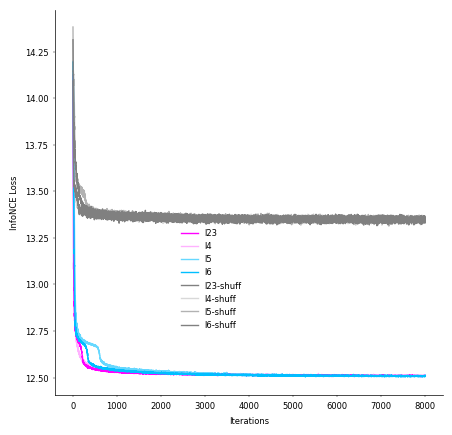

In [10]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(111)

# data
ax = cebra.plot_loss(cebra_l23_model, color="magenta", label="l23", ax=ax)
ax = cebra.plot_loss(cebra_l4_model, color="magenta", alpha=0.3, label="l4", ax=ax)
ax = cebra.plot_loss(cebra_l5_model, color="deepskyblue", alpha=0.6, label="l5", ax=ax)

ax = cebra.plot_loss(cebra_l6_model, color="deepskyblue", label="l6", ax=ax)

# shuffled
ax = cebra.plot_loss(shuff_cebra_l23_model, color="gray", label="l23-shuff", ax=ax)
ax = cebra.plot_loss(
    shuff_cebra_l4_model, color="gray", alpha=0.3, label="l4-shuff", ax=ax
)
ax = cebra.plot_loss(
    shuff_cebra_l5_model, color="gray", alpha=0.6, label="l5-shuff", ax=ax
)

ax = cebra.plot_loss(shuff_cebra_l6_model, color="gray", label="l6-shuff", ax=ax)

# legend
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Iterations")
ax.set_ylabel("InfoNCE Loss")
plt.legend(bbox_to_anchor=(0.5, 0.3), frameon=False)

# save
plt.savefig(PROJ_PATH + "/figures/cell_type/cebra_hyb_dir_exc_loss.svg", **savefig_cfg)

#### Embed

<Figure size 200x100 with 0 Axes>

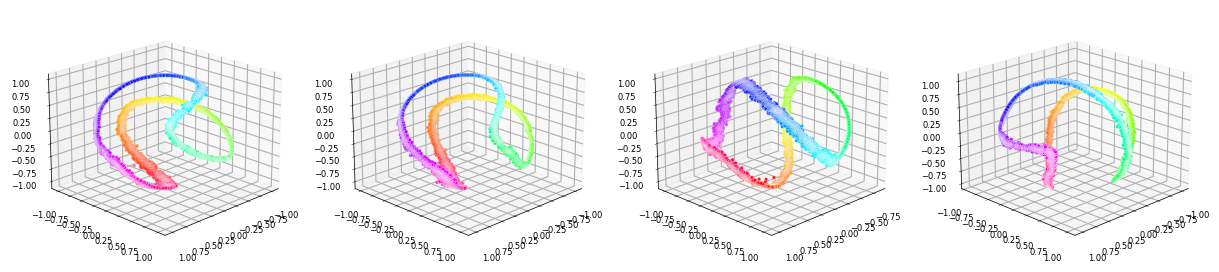

In [14]:
SIZE = 6

# init plot
plt.set_cmap("hsv")  # circular cmap
fig = plt.figure(figsize=(15, 4))

# plot
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    cebra_l23_embed[:, 0],
    cebra_l23_embed[:, 1],
    cebra_l23_embed[:, 2],
    c=stimulus_labels,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    cebra_l4_embed[:, 0],
    cebra_l4_embed[:, 1],
    cebra_l4_embed[:, 2],
    c=stimulus_labels,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot ******************************************
ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    cebra_l5_embed[:, 0],
    cebra_l5_embed[:, 1],
    cebra_l5_embed[:, 2],
    c=stimulus_labels,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
ax = fig.add_subplot(1, 4, 4, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    cebra_l6_embed[:, 0],
    cebra_l6_embed[:, 1],
    cebra_l6_embed[:, 2],
    c=stimulus_labels,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,
)

# save
plt.savefig(PROJ_PATH + "/figures/cell_type/cebra_hyb_dir_exc_embed.svg", **savefig_cfg)

#### Decoding

In [21]:
# split
train_idx, test_idx = split(trial_labels, n_rep=50, train_ratio=0.2)

# decode
dir_test_err_l23, dir_test_score_l23 = decode(
    cebra_l23_embed[train_idx, :],
    cebra_l23_embed[test_idx, :],
    labels[train_idx, :],
    labels[test_idx, :],
)

print("\nL23")
print("error dir:")
print(dir_test_err_l23)
print(dir_test_score_l23)

# shuffled
(
    shuff_dir_test_err_l23,
    shuff_dir_test_score_l23,
) = decode(
    shuff_cebra_l23_embed[train_idx, :],
    shuff_cebra_l23_embed[test_idx, :],
    shuff_labels[train_idx, :],
    shuff_labels[test_idx, :],
)
print("\nL23")
print("error dir:")
print(shuff_dir_test_err_l23)
print(shuff_dir_test_score_l23)

# decode
dir_test_err_l4, dir_test_score_l4 = decode(
    cebra_l4_embed[train_idx, :],
    cebra_l4_embed[test_idx, :],
    labels[train_idx, :],
    labels[test_idx, :],
)

print("\nL4 ********")
print("error dir:")
print(dir_test_err_l4)
print(dir_test_score_l4)

# shuffled
(
    shuff_dir_test_err_l4,
    shuff_dir_test_score_l4,
) = decode(
    shuff_cebra_l4_embed[train_idx, :],
    shuff_cebra_l4_embed[test_idx, :],
    shuff_labels[train_idx, :],
    shuff_labels[test_idx, :],
)
print("\nL4")
print("error dir:")
print(shuff_dir_test_err_l4)
print(shuff_dir_test_score_l4)

# decode
dir_test_err_l5, dir_test_score_l5 = decode(
    cebra_l5_embed[train_idx, :],
    cebra_l5_embed[test_idx, :],
    labels[train_idx, :],
    labels[test_idx, :],
)

print("\nL5 ********")
print("error dir:")
print(dir_test_err_l5)
print(dir_test_score_l5)


# shuffled
(
    shuff_dir_test_err_l5,
    shuff_dir_test_score_l5,
) = decode(
    shuff_cebra_l5_embed[train_idx, :],
    shuff_cebra_l5_embed[test_idx, :],
    shuff_labels[train_idx, :],
    shuff_labels[test_idx, :],
)
print("\nL5")
print("error dir:")
print(shuff_dir_test_err_l5)
print(shuff_dir_test_score_l5)

# decode
dir_test_err_l6, dir_test_score_l6 = decode(
    cebra_l6_embed[train_idx, :],
    cebra_l6_embed[test_idx, :],
    labels[train_idx, :],
    labels[test_idx, :],
)

print("\nL6 ********")
print("error dir:")
print(dir_test_err_l6)
print(dir_test_score_l6)

# shuffled
(
    shuff_dir_test_err_l6,
    shuff_dir_test_score_l6,
) = decode(
    shuff_cebra_l6_embed[train_idx, :],
    shuff_cebra_l6_embed[test_idx, :],
    shuff_labels[train_idx, :],
    shuff_labels[test_idx, :],
)
print("\nL6")
print("error dir:")
print(shuff_dir_test_err_l6)
print(shuff_dir_test_score_l6)


L23
error dir:
1.305555555555543
0.9739446983324769

L23
error dir:
89.19444444444446
-0.025589888442518527

L4 ********
error dir:
1.4722222222222285
0.9348461822763554

L4
error dir:
89.81944444444444
-0.038321676099523305

L5 ********
error dir:
1.2777777777777715
0.9724716658742409

L5
error dir:
89.58333333333334
-0.02955571450489436

L6 ********
error dir:
1.055555555555543
0.964783379278581

L6
error dir:
90.45833333333334
-0.028389070234010605


#### Plot

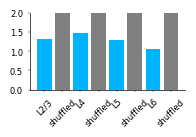

In [40]:
plt.bar(
    x=[1, 2, 3, 4, 5, 6, 7, 8],
    height=[
        dir_test_err_l23,
        shuff_dir_test_err_l23,
        dir_test_err_l4,
        shuff_dir_test_err_l4,
        dir_test_err_l5,
        shuff_dir_test_err_l5,
        dir_test_err_l6,
        shuff_dir_test_err_l6,
    ],
    color=[(0, 0.7, 1), "grey"],
)
plt.ylim([0, 2])
plt.xticks(
    [1, 2, 3, 4, 5, 6, 7, 8],
    ["L2/3", "shuffled", "L4", "shuffled", "L5", "shuffled", "L6", "shuffled"],
    rotation=45,
)

# save
plt.savefig(
    PROJ_PATH + "/figures/cell_type/cebra_hyb_dir_exc_decoding.svg", **savefig_cfg
)

#### Consistency

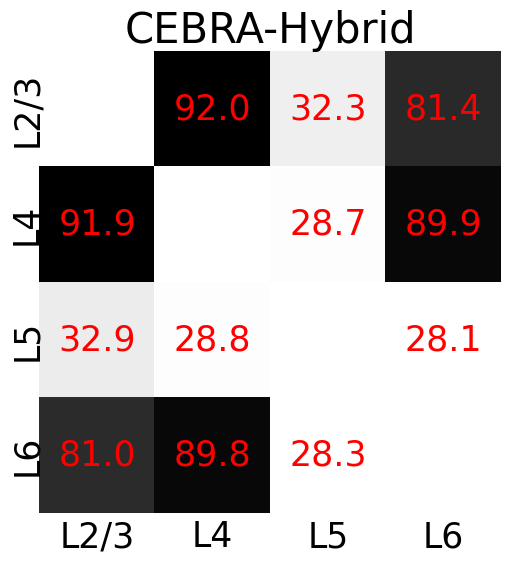

In [41]:
plt.rcParams["font.size"] = 25
fig, ax = plt.subplots(figsize=(6, 6))

dir_scores, dir_pairs, dir_layer = cebra.sklearn.metrics.consistency_score(
    embeddings=[
        cebra_l23_embed,
        cebra_l4_embed,
        cebra_l5_embed,
        cebra_l6_embed,
    ],
    labels=[labels[:, 0], labels[:, 0], labels[:, 0], labels[:, 0]],
    dataset_ids=["L2/3", "L4", "L5", "L6"],
    between="datasets",
)

ax = cebra.plot_consistency(
    dir_scores,
    pairs=dir_pairs,
    datasets=dir_layer,
    ax=ax,
    title="CEBRA-Hybrid",
    colorbar_label=None,
    text_color="r",
)

# save
plt.savefig(
    PROJ_PATH + "/figures/cell_type/cebra_hyb_dir_exc_consistency.svg", **savefig_cfg
)